<a href="https://colab.research.google.com/github/21Ovi/TensorFlow_/blob/main/05_Transfer_Learning_in_TensorFlow_03_Scaling_Up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 3: Scaling-Up (Food Vision mini)

We've seen the power of transfer learning `Feature Extraction` and  `Fine-Funing`, now it's time to scale up to all of the classes in Food101 (101 total classes of food).

Our goal is to beat the orignal Food101 paper with 10% of the training (leveraging the power of deep learning)

Orignal Food101 paper : https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our base line to beat is 50.76% accuracy across 101 classes

In [1]:
# Check to see if we're using a GPU
!nvidia-smi

Mon Jun  5 16:49:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we've created a series of helper functions to do different tasks, let's download them.


In [2]:
!wget https://raw.githubusercontent.com/21Ovi/Helper-Functions/main/helper_functions.py

--2023-06-05 16:49:04--  https://raw.githubusercontent.com/21Ovi/Helper-Functions/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10116 (9.9K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.88K  --.-KB/s    in 0s      

2023-06-05 16:49:04 (55.0 MB/s) - ‘helper_functions.py’ saved [10116/10116]



In [3]:
# Import series of helper functions for our notebooks
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: working with less data

Our goal is to beat the orignal Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the orignal Food101 dataset but has been preprocessed using the image_adta_modification notebook - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

--2023-06-05 16:49:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.128, 173.194.202.128, 173.194.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  76.0MB/s    in 21s     

2023-06-05 16:49:29 (74.5 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# How manu images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/sashimi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/frozen_yogurt'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/shrimp_and_grits'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beignets'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/lasagna'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pork_chop'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/fish_and_chips'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/breakfast_burrito'.
There are 0 directories and 250 images i

In [6]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE, 
                                                                shuffle=False) # Don't shuffle for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 foor class

Here are the steps we're going to take :
* Create a ModelCheckpoint callback
* Craete a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNEtB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 rpochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [7]:
# Create checkpoint callback
checkpoint_path = "101_classes_1-_percent_data_model_checkpoint"
checkpoint_callbacks = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                          save_weights_only=True,
                                                          monitor="val_accuracy",
                                                          save_best_only=True)

In [8]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Seetup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    # preprocessing.Rescaling(1/255.) # Rescale imputs of image to between 0 & 1, required for model like ResNet50
], name="data_augmentation")

In [9]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name = "input_layer")
x = data_augmentation(inputs) # augments images (only happens during training phase)
x = base_model(x, training = False) # put the base model in inference mode so weights which needs to stay forzen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [10]:
# Get a summary of model we've created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [11]:
# Compile the model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_all_class_10_percent = model.fit(train_data_all_10_percent,
                                         epochs=5,
                                         validation_data=test_data,
                                         validation_steps=int(0.15 * len(test_data)),
                                         callbacks=[checkpoint_callbacks])

Epoch 1/5
237/237 [==============================] - 111s 400ms/step - loss: 3.3614 - accuracy: 0.2780 - val_loss: 2.4614 - val_accuracy: 0.4778
Epoch 2/5
237/237 [==============================] - 73s 305ms/step - loss: 2.2006 - accuracy: 0.4999 - val_loss: 2.0517 - val_accuracy: 0.5180
Epoch 3/5
237/237 [==============================] - 64s 271ms/step - loss: 1.8274 - accuracy: 0.5659 - val_loss: 1.9200 - val_accuracy: 0.5228
Epoch 4/5
237/237 [==============================] - 61s 257ms/step - loss: 1.6061 - accuracy: 0.6120 - val_loss: 1.8268 - val_accuracy: 0.5384
Epoch 5/5
237/237 [==============================] - 54s 226ms/step - loss: 1.4584 - accuracy: 0.6444 - val_loss: 1.7841 - val_accuracy: 0.5413


In [12]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 56s 71ms/step - loss: 1.5788 - accuracy: 0.5862


[1.5787537097930908, 0.5861782431602478]

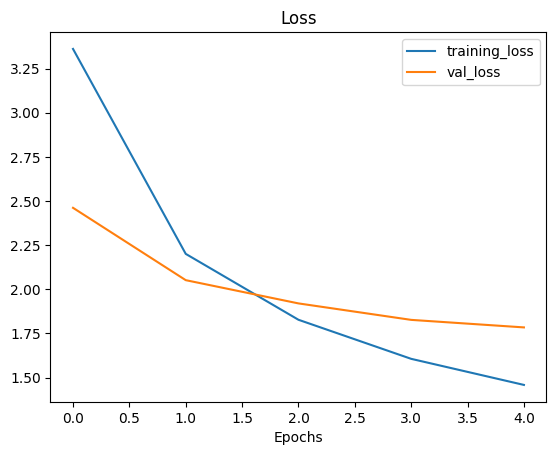

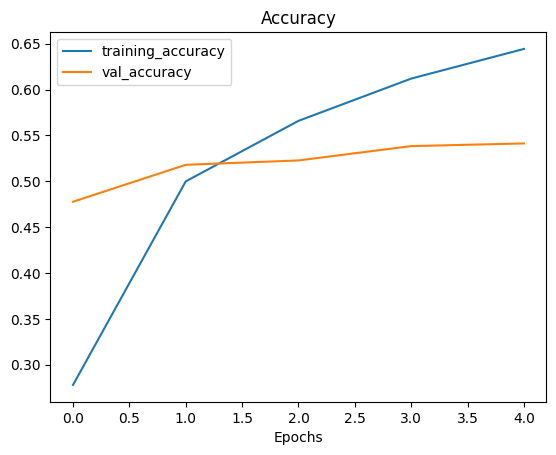

In [13]:
plot_loss_curves(history_all_class_10_percent)

> **Question:** What do these curves suggest? Hint: Ideally, the two curves should be very similar to each other if not it mau suggest that our model is overfitting (performing too well on training data and not generalizing in unseen data)

## Fine Tuning

In [25]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [26]:
# Recompile model with lower learning rate (its typically the best practice to lower the learning rate when fine-tuning)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # learning rate lowered by 10x (rule of thumb)
              metrics=["accuracy"])

In [27]:
# What model in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [28]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [31]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs (feature extraction), this is the total number of epochs we're after (5 + 5 = 10)

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_class_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 47s 197ms/step - loss: 0.7780 - accuracy: 0.7951 - val_loss: 1.7372 - val_accuracy: 0.5516
Epoch 6/10
237/237 [==============================] - 40s 167ms/step - loss: 0.7298 - accuracy: 0.8038 - val_loss: 1.7215 - val_accuracy: 0.5553
Epoch 7/10
237/237 [==============================] - 44s 183ms/step - loss: 0.7093 - accuracy: 0.8086 - val_loss: 1.7837 - val_accuracy: 0.5456
Epoch 8/10
237/237 [==============================] - 54s 221ms/step - loss: 0.6556 - accuracy: 0.8263 - val_loss: 1.7361 - val_accuracy: 0.5514
Epoch 9/10
237/237 [==============================] - 52s 216ms/step - loss: 0.6297 - accuracy: 0.8300 - val_loss: 1.7509 - val_accuracy: 0.5530
Epoch 10/10
237/237 [==============================] - 40s 170ms/step - loss: 0.5833 - accuracy: 0.8500 - val_loss: 1.8395 - val_accuracy: 0.5360


In [32]:
# Evaluate on the whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 65s 82ms/step - loss: 1.5415 - accuracy: 0.6023


[1.54146409034729, 0.6022574305534363]

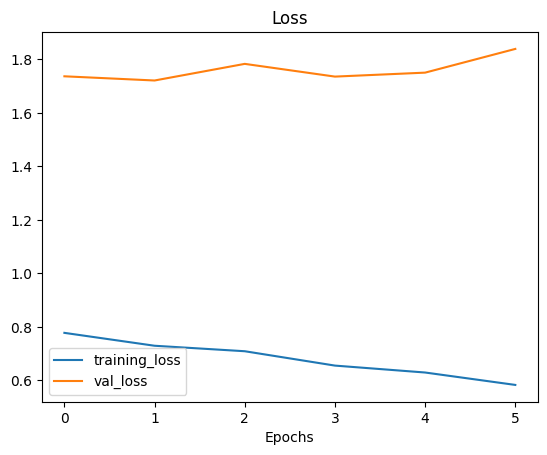

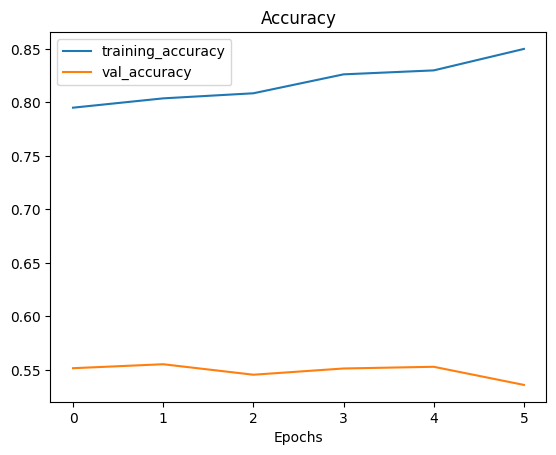

In [33]:
plot_loss_curves(history_all_classes_10_percent_fine_tune)

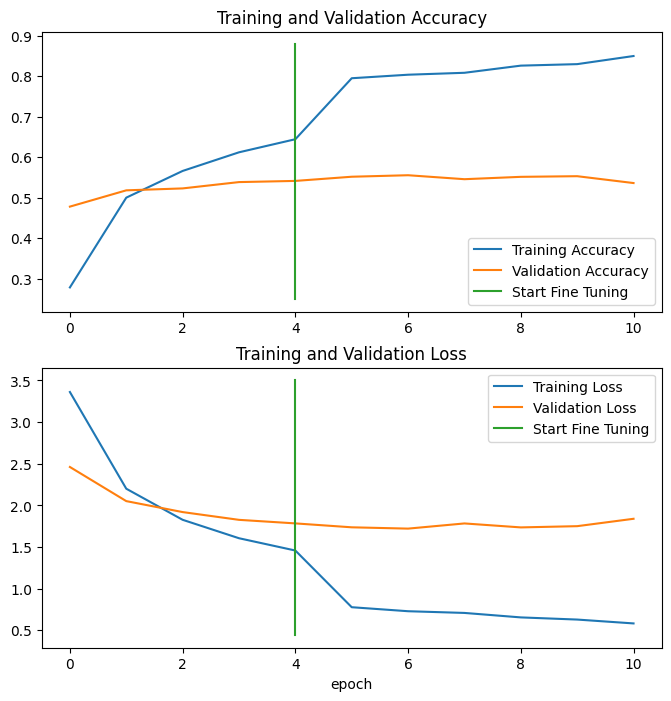

In [36]:
# Compare the histories of feature extraction model with the fine tune model\
compare_historys(original_history=history_all_class_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)